# ST 590 

# Final-Project-Jingjing-Li_Smitali-Patnaik

#### Date of Submission : 08/02/2022

## Introduction|

This project is to use **Paris Housing Dataset** from Kaggle (https://www.kaggle.com/datasets/mssmartypants/paris-housing-price-prediction) to perform  **Exploratory Data Analysis (EDA)** and **Machine Learning (ML)** via through `pandas-on-spark` and/or `spark SQL`. TThe data has following variables: `squareMeters`, `numberOfRooms` `hasYard` `hasPool`, `loors`, `cityCode`, `cityPartRange`, `isnumPrevOwners` , `isNewBuilt`, `hasStormProtector`,`basement`, `attic`, `garage`, `hasStorageRoom`, `hasGuestRoom`, `price`  - used as response variable. All the variables are numeric. Aside from first four,  `isNewBuilt`, `hasStormProtector` and `hasStorageRoom`which are easily understandable, the meanings of others are shown next: `floors` - number of floors; `cityCode` - zip code;`ityPartRange`- the higher the range, the more exclusive the neighbourhood is; `numPrevOwners` - number of prevoious owners; `made` - year; `basement` - basement square meters; `attic` - attic square meteres, `garage` - garage size, `hasGuestRoom` - number of guest rooms, `price `- predicted value. The data is read in in spark form followed by splitting into two sets : `training` and `test` for `modeling` and `prediction`respectively. In **EDA**, spark dataframe is first converted into `pandas-value-spark` dataframe and then subjected to table constructions and graph plotting. In **modeling**, three Machine Learning models,  `Linear regressions`, `Decision Tree  Regression` and `Random Forest Regression`, will be implemented here.  

## Supervised Learning Idea and Data Split

Supervised Learning, one of machine learning methods usually involves in prediction or classification of a response variable or output based on paired  predictive variables or inputs. In this project, the price of Paris housing which is our response variable will be predicted from input variables such as `sparemeters` etc using three models mentioned in the introduction. The quality of three models will be assessed using **Root mean squared error (RMSE)** and the **R-squared (R2)** which are smaller and greater in better models. It is reasonable that more variables added to models will increase R2 and decrease RMSE even though those variables have weak relationship with resposne variable. As a result, the model will result in over-fitting, which won't be widely applicable. An efficient strategy to address over-fitting problem is to split data into training and test sets. The test set can be used to check if training model is reliable.   `Pyspark  mlib library` is used to develop pipeline and `cross validation`is adopted to fit on the training data to get optimized parameters. The output from the `cross validation` fit then will be used to predict response variable and compare it with corresponding actual value. `Cross validation` is a analogous method to training/test split data. It usually split data into different training/test sets for several times (called k value, usually 5 or 10) and resulting estimation errors will be averaged. This method can significantly decrease the bias of fitting.   

### Importing required libraries and packages.

In [1]:
# Prepare the environment for Windows operation systems
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
#os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"   ##### Some other warnings due to version - Smitali 
# Import the modules
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from sklearn.model_selection import train_test_split, GridSearchCV,cross_validate

# Create a new Spark session
spark = SparkSession.builder.getOrCreate()

# Configurate the Spark session
ps.set_option("compute.default_index_type", "distributed")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)
#spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", False) #### Shows as warning in my python version so I am using it as False -Smitali


### Reading the dataset 

In [95]:
# Read in data using spark
spdf=spark.read.load("ParisHousing.csv",
                     format="csv",sep=",", inferSchema="true", header="true")
spdf.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|    price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+
|       75523|            3|      0|      1|    63|    9373|            3|            8|2005|         0|                1|    4313| 9005|   956|             0|           7|7559081.5|
|       80771|           39|      1|      1|    98|   39381|            8|            6|2015|         1|                0|    3653| 2436|   128|             1|           2|8085989.5|
|       55712|           58|      0|      1|    19|   34457|            6|           

### Split data 
Then, we split data into two parts for train and test respectively.

In [202]:
# Split data
train, test = spdf.randomSplit(weights=[0.8,0.2], seed=200)

### Transform response variable
For the purpose of EDA we have split the price column into categories. We have used 3 categories here for the price. '0', '1' and '2' represent "Low Price",  "Medium Price" and  "High Price" respectively.

In [210]:
from pyspark.sql.functions import when
quantiles = train.approxQuantile("price", [0.25, 0.5, 0.75], 0)
train = train.withColumn("cat_price", when(spdf.price <= quantiles[0] ,0) \
      .when((spdf.price > quantiles[0]) & (spdf.price <= quantiles[1] ),1) \
      .otherwise(2))
train.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+---------+------------------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|  price|cat_price|         rlt_price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+---------+------------------+
|          89|           33|      0|      0|    72|   61648|            3|            4|1995|         0|                1|    3114| 1258|   264|             1|           9|10313.5|        0| 1.158820224719101|
|         111|           32|      0|      1|    34|   80623|            1|            4|2003|         1|                0|    2239| 2795|   951|             1| 

In [211]:
train=train.withColumn("rlt_price", spdf.price/(spdf.squareMeters*100))
train.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+---------+------------------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|  price|cat_price|         rlt_price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+---------+------------------+
|          89|           33|      0|      0|    72|   61648|            3|            4|1995|         0|                1|    3114| 1258|   264|             1|           9|10313.5|        0| 1.158820224719101|
|         111|           32|      0|      1|    34|   80623|            1|            4|2003|         1|                0|    2239| 2795|   951|             1| 

## EDA

### Data transformation 
Here the spark dataframe is converted to "pandas on spark dataframe" and the data is studied using plots and tables. 

In [212]:
train_ps=train.to_pandas_on_spark()
#train_ps=train.pandas_api() #### shows deprecated at my end , so I am using API-Smitali 

C:\Users\li_ji\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\dataframe.py:3313: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


### Distribution of variable values
To see the distribution of variables, we plot the histograms of 16 variables except for cityCode which doesn't make sense for analysis. 

<AxesSubplot:title={'center':'hasGuestRoom'}, ylabel='Frequency'>

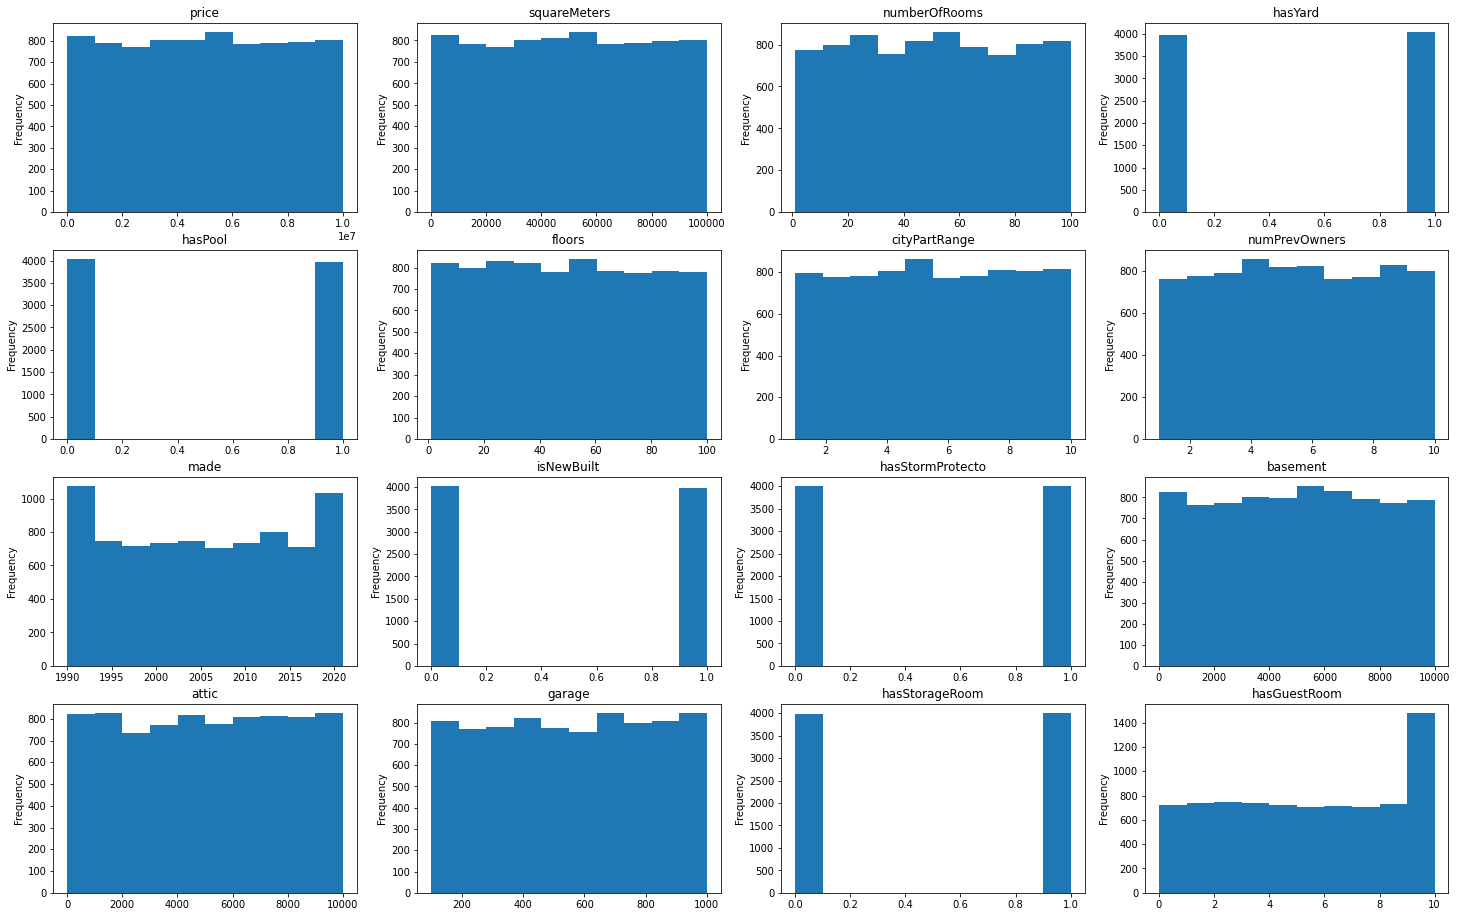

In [234]:
from matplotlib.pyplot import figure
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 16 ))
train_ps['price'].hist(ax=axes[0,0],title='price')
train_ps['squareMeters'].hist(ax=axes[0,1],title='squareMeters')
train_ps['numberOfRooms'].hist(ax=axes[0,2],title='numberOfRooms')
train_ps['hasYard'].hist(ax=axes[0,3], title='hasYard')
train_ps['hasPool'].hist(ax=axes[1,0], title='hasPool')
train_ps['floors'].hist(ax=axes[1,1], title='floors')
train_ps['cityPartRange'].hist(ax=axes[1,2], title='cityPartRange')
train_ps['numPrevOwners'].hist(ax=axes[1,3], title='numPrevOwners')
train_ps['made'].hist(ax=axes[2,0], title='made')
train_ps['isNewBuilt'].hist(ax=axes[2,1], title='isNewBuilt')
train_ps['hasStormProtector'].hist(ax=axes[2,2], title='hasStormProtecto')
train_ps['basement'].hist(ax=axes[2,3], title='basement')
train_ps['attic'].hist(ax=axes[3,0], title='attic')
train_ps['garage'].hist(ax=axes[3,1], title='garage')
train_ps['hasStorageRoom'].hist(ax=axes[3,2], title='hasStorageRoom')
train_ps['hasGuestRoom'].hist(ax=axes[3,3], title='hasGuestRoom')

 We checked if any normality can be seen in the price variable and squareMeter variable. However, it does not any indication of that. But We do see "made" and "hasGestroom" have bias distribution. More houses(probably > 30%) are built before 1992 and after 2017. The houses with more than 10 guestrooms are twice more than the others. Discrete variable simply quantifies the binary variables. All binary variables including "hasYarcd", "hasPool", "isNewBuilt", "hasStormProtecto", "hasStorageRoom" show equal frequency, indicating nonpreference. 

### Relationship between variables
Next, we are interested in seeing if there is relationship between the Predictors and the predicted variable. This starts with quantifying the correlation between the variables.

In [213]:
train_ps.corr()

C:\Users\li_ji\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\pandas\conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: MatrixUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,cat_price,rlt_price
squareMeters,1.000000,0.018112,-0.006920,-0.007275,0.001266,0.003348,0.009571,0.021107,-0.011790,-0.017515,0.013962,-0.003347,0.000494,-0.021376,0.000758,-0.005259,0.999999,0.913700,-0.279082
numberOfRooms,0.018112,1.000000,-0.002026,0.025064,0.025580,0.008786,0.003964,0.022695,0.006171,0.002984,-0.019973,-0.012659,0.017830,0.020140,-0.007714,-0.028996,0.018139,0.025758,-0.007631
hasYard,-0.006920,-0.002026,1.000000,0.022319,0.007221,0.011608,0.000510,0.013940,-0.001031,-0.019186,-0.014477,-0.012269,-0.008550,-0.009474,-0.016018,-0.009306,-0.006379,-0.008062,0.032506
hasPool,-0.007275,0.025064,0.022319,1.000000,-0.004498,0.002839,0.010935,-0.011100,0.004553,-0.000551,0.008231,-0.004457,-0.010662,0.003959,0.002272,0.010486,-0.006744,0.003918,0.065044
floors,0.001266,0.025580,0.007221,-0.004498,1.000000,0.003560,0.003539,0.002120,0.008657,0.011376,-0.009689,0.013451,0.007498,0.013224,0.004201,-0.015645,0.001813,-0.001144,0.045163
cityCode,0.003348,0.008786,0.011608,0.002839,0.003560,1.000000,0.006340,-0.010801,0.022962,0.002324,0.002648,0.000262,-0.001843,-0.000273,0.002974,-0.000929,0.003354,-0.006708,-0.007561
cityPartRange,0.009571,0.003964,0.000510,0.010935,0.003539,0.006340,1.000000,0.007545,0.001559,-0.000573,0.011112,0.005079,0.010184,0.006154,-0.011989,-0.007684,0.009624,0.008821,-0.000809
numPrevOwners,0.021107,0.022695,0.013940,-0.011100,0.002120,-0.010801,0.007545,1.000000,0.002941,-0.019256,0.003950,0.006442,0.002745,0.023401,0.031660,-0.004088,0.021112,0.023417,-0.029085
made,-0.011790,0.006171,-0.001031,0.004553,0.008657,0.022962,0.001559,0.002941,1.000000,-0.005893,-0.005240,-0.008512,0.007095,0.014569,-0.008558,-0.010441,-0.011787,-0.009155,-0.001481
isNewBuilt,-0.017515,0.002984,-0.019186,-0.000551,0.011376,0.002324,-0.000573,-0.019256,-0.005893,1.000000,-0.000760,-0.012884,0.023872,-0.001470,0.002765,0.026291,-0.017491,-0.016424,0.004486


Correlation table states that only squareMeters has the strongest linear relationship with price variable. Other variables do not show any significant relationship. As we see there are also many discrete variables in the data. The relationship may not be strong with a simple correlation step.

### Contingency tables

We are here now taking the categorical datasets and checking relationship between them with a simple contingency table.

In [235]:
# Import modules
from pyspark.mllib.stat import Statistics
from pyspark.sql import DataFrame

# Overview dataframe
train_ps.head(5)

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,cat_price,rlt_price,price_cat_name
0,89,33,0,0,72,61648,3,4,1995,0,1,3114,1258,264,1,9,10313.5,0,1.158820,Low_price
1,111,32,0,1,34,80623,1,4,2003,1,0,2239,2795,951,1,7,14431.3,0,1.300117,Low_price
2,123,61,0,0,1,33633,9,1,2011,0,1,9390,6219,922,0,9,13229.1,0,1.075537,Low_price
3,128,38,0,1,6,8862,6,2,1990,0,0,6861,5769,442,0,5,15488.0,0,1.210000,Low_price
4,141,16,0,1,58,42248,5,4,1997,1,0,3411,8985,213,0,4,22670.7,0,1.607851,Low_price


As the price range is too wide. We are using the category column of the price to study relationship with descrete variables and some relevant numeric variables. A pivot rable hasbeen used here to get the summary of the categories.  Columns 'hasYard','hasPool','isNewBuilt','hasStormProtector','hasStorageRoom','hasGuestRoom','made' have been selected to know which category of price these features fall into.

In [215]:
train_ps.loc[train_ps['cat_price']==0,'price_cat_name']='Low_price'
train_ps.loc[train_ps['cat_price']==1,'price_cat_name']='Medium_price'
train_ps.loc[train_ps['cat_price']==2,'price_cat_name']='High_price'

In [216]:
dis_col=['hasYard','hasPool','isNewBuilt','hasStormProtector','hasStorageRoom','hasGuestRoom']
for i in dis_col:
    table = train_ps.pivot_table(values=i, index=[i],columns='price_cat_name', aggfunc='count',fill_value=0)
    print(table)


price_cat_name  High_price  Low_price  Medium_price
hasYard                                            
1                     2015       1032           992
0                     1987        969          1009
price_cat_name  High_price  Low_price  Medium_price
hasPool                                            
1                     1980        975          1013
0                     2022       1026           988
price_cat_name  High_price  Low_price  Medium_price
isNewBuilt                                         
1                     1953       1013          1012
0                     2049        988           989
price_cat_name     High_price  Low_price  Medium_price
hasStormProtector                                     
1                        2010        990           995
0                        1992       1011          1006
price_cat_name  High_price  Low_price  Medium_price
hasStorageRoom                                     
1                     1992       1007          1014


High Price Houses show following features- they have yard and pool irrespective of being old or new and year they were constructed. Having a storage room or not did not have signifcant impact on price being in High category. Medium price houses mostly have all the features at par with Low Price Houses.

We then check if years of construction show any trend or  any significant relations with price. 

made            1990  1991  1992  1993  1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021
price_cat_name                                                                                                                                                                                                
Medium_price      60    78    66    72    72    53    67    56    60    55    57    66    63    68    50    59    61    54    67    67    55    62    61    82    56    66    55    62    61    56    71    63
Low_price         63    69    66    60    65    60    60    70    68    52    60    60    52    64    66    64    47    51    60    57    61    61    64    80    74    55    63    56    72    81    66    54
High_price       140   114   154   134   120   113   138   115   114   125   116   143   116   131   129   116   135   127   105   124   118   130   123   132   127   119  

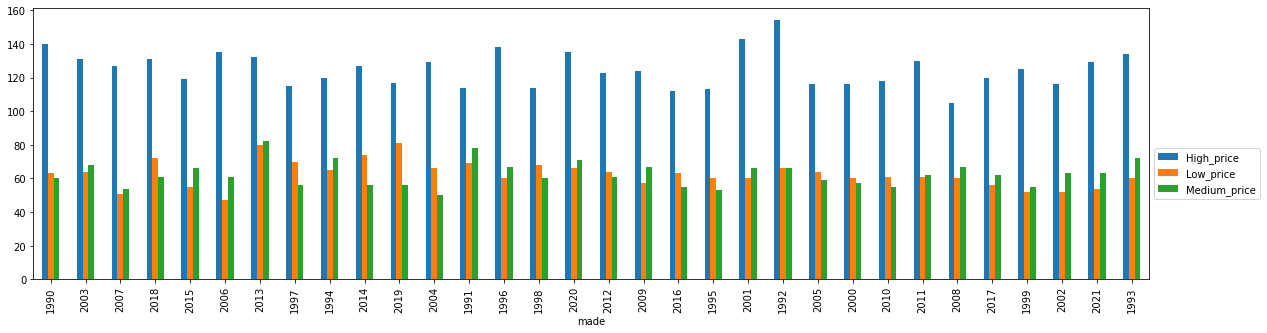

In [217]:
from matplotlib.pyplot import figure
ps.options.plotting.backend = 'matplotlib'

##sorting the data as per year
df_train_sort=train_ps.sort_values(by=['made'])
table3=df_train_sort.groupby(['price_cat_name','made',])['price_cat_name'].count().unstack(level=1)
print(table3)

df_train_sort.pivot_table(values='made', index=['made'],columns='price_cat_name', aggfunc='count',fill_value=0).plot.bar(stacked=False)
plt.gcf().set_size_inches(20, 5)
plt.legend( bbox_to_anchor=(1, 0.5))


It does not seem to be giving much information. Except High range houses were built more in quantity that those in medium and low price category. It also shows that none of the price categories show any significant ups or lows in since 1900s and this trend pretty much stayed as it is. 

We are interested to see if "hasPool" has any effect on other variables

### Numeric summary

In [244]:
train_ps[['squareMeters','numberOfRooms','basement','attic','garage','hasGuestRoom','price','rlt_price']].describe() 

,squareMeters,numberOfRooms,basement,attic,garage,hasGuestRoom,price,rlt_price
count,8004.000000,8004.000000,8004.000000,8004.000000,8004.000000,8004.000000,8.004000e+03,8004.000000
mean,49933.997626,50.583208,4994.160170,5021.567966,553.670290,4.996377,4.999808e+06,1.004731
std,28857.052125,28.812682,2874.785407,2910.388369,261.223796,3.178572,2.885693e+06,0.021380
min,89.000000,1.000000,0.000000,4.000000,100.000000,0.000000,1.031350e+04,1.000048
25%,25004.000000,25.000000,2513.000000,2474.000000,328.000000,2.000000,2.508814e+06,1.000718
50%,50102.000000,51.000000,5047.000000,5027.000000,555.000000,5.000000,5.015730e+06,1.001289
75%,74880.000000,75.000000,7449.000000,7559.000000,776.000000,8.000000,7.494846e+06,1.002564
max,99999.000000,100.000000,10000.000000,9999.000000,1000.000000,10.000000,1.000677e+07,1.607851


##### As per correlation table we see that aquare meters has the most linear relationship with the price . Number of rooms also did not have any relation with the price variable

<AxesSubplot:title={'center':'price vs made'}, xlabel='made', ylabel='rlt_price'>

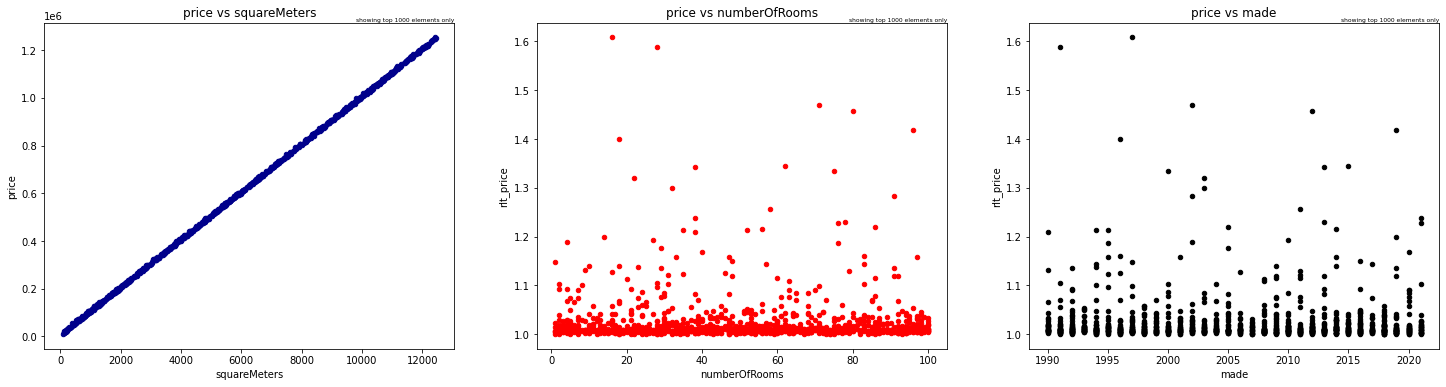

In [220]:
import numpy as np 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6 ))
train_ps.plot(kind='scatter',x='squareMeters',y='price',color='darkblue',ax=axes[0],title='price vs squareMeters')
train_ps.plot(kind='scatter',x='numberOfRooms',y='rlt_price',color='red', ax=axes[1],title='price vs numberOfRooms')
train_ps.plot(kind='scatter',x='made',y='rlt_price',color='black',ax=axes[2],title='price vs made')

##### Box plot of the discrete variable quanties the range of houses having and not having yard with repect to squareMeters and price. The spread in both cases is almost similar.

<AxesSubplot:title={'center':'hasStorageRoom=1'}>

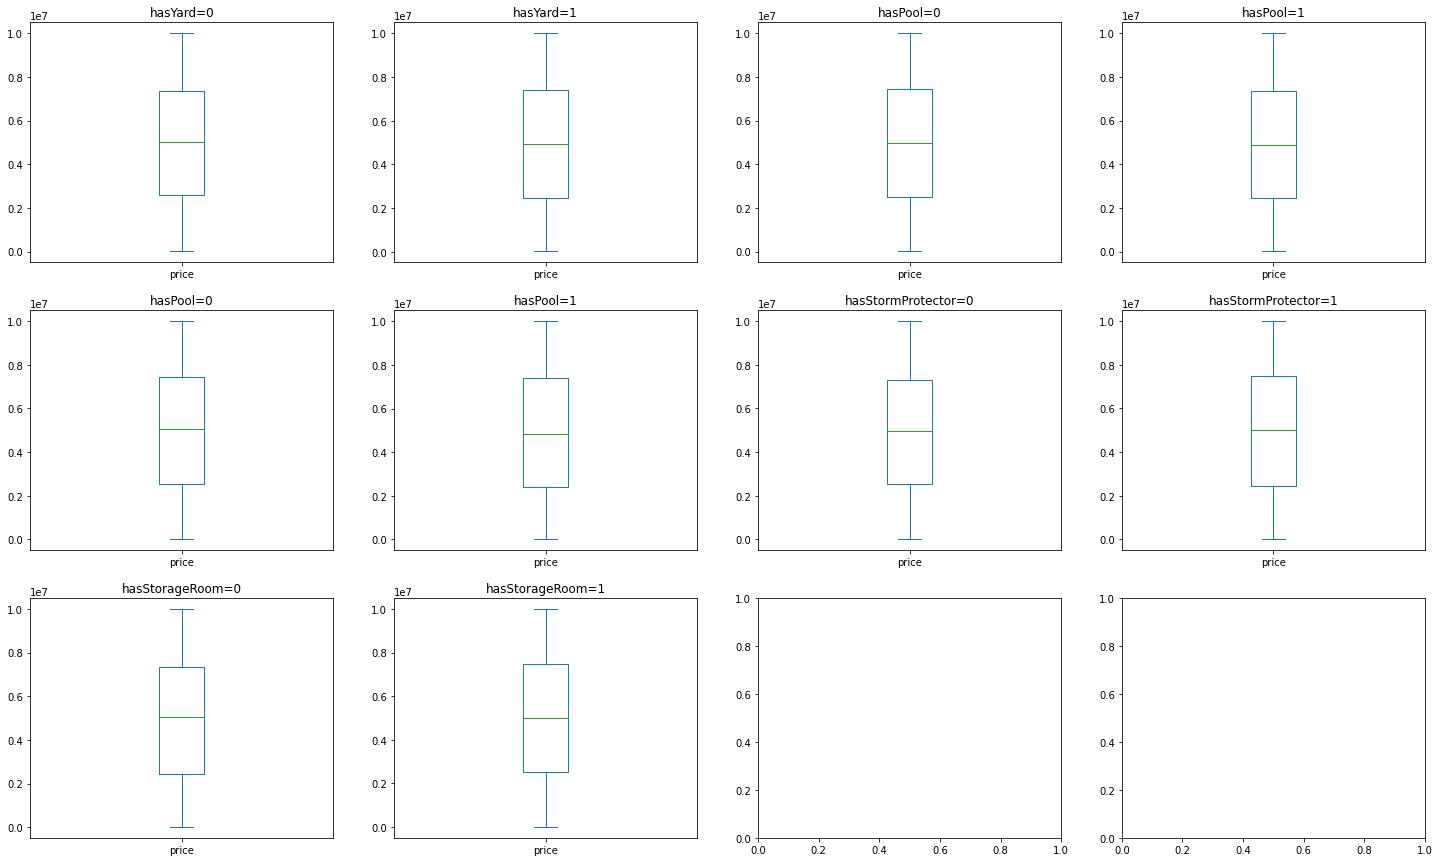

In [222]:
#train_ps['price'].plot.box(by=train_ps['hasYard','hasStorageRoom'])
fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(25,15))
train_ps.loc[train_ps['hasYard']==0,'price'].plot.box(ax=axes[0,0], title='hasYard=0') 
train_ps.loc[train_ps['hasYard']==1,'price'].plot.box(ax=axes[0,1], title='hasYard=1')
train_ps.loc[train_ps['hasPool']==0,'price'].plot.box(ax=axes[0,2], title='hasPool=0')
train_ps.loc[train_ps['hasPool']==1,'price'].plot.box(ax=axes[0,3],title='hasPool=1')
train_ps.loc[train_ps['isNewBuilt']==0,'price'].plot.box(ax=axes[1,0], title='hasPool=0')
train_ps.loc[train_ps['isNewBuilt']==1,'price'].plot.box(ax=axes[1,1],title='hasPool=1')
train_ps.loc[train_ps['hasStormProtector']==0,'price'].plot.box(ax=axes[1,2], title='hasStormProtector=0')
train_ps.loc[train_ps['hasStormProtector']==1,'price'].plot.box(ax=axes[1,3],title='hasStormProtector=1')
train_ps.loc[train_ps['hasStorageRoom']==0,'price'].plot.box(ax=axes[2,0], title='hasStorageRoom=0')
train_ps.loc[train_ps['hasStorageRoom']==1,'price'].plot.box(ax=axes[2,1],title='hasStorageRoom=1')



## Modeling

##### Import modules for modeling. Some are repeated just for sanity

In [223]:
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

### Linear Regression modeling

##### Linear regression model has been implemented using the log of squareMeter, hasYard variable and numberOfRooms. As we did not see significant relation between the numberOfrROoms and hasYard variables. We have tried fitting a multiple linear regression with polynomial fit in a pipe line. First the training predictors are fit into the polynomialExpansion and the features obtained from this are then used as input in the regression model fit. The trained model is finally used to get the predictions for the test data. Log of squareMeters and price is used to scale these two variables.

In [224]:
# Choose variables for transformation 
sqlTrans=SQLTransformer(
    statement="SELECT  log(squareMeters) as log_squareMeters, hasYard, numberOfRooms, log(price) as label FROM __THIS__"
)

##### Getting train dataset

In [225]:
# Check if sqlTrans works or not
sqlTrans.transform(train).show(5)

+-----------------+-------+-------------+-----------------+
| log_squareMeters|hasYard|numberOfRooms|            label|
+-----------------+-------+-------------+-----------------+
| 4.48863636973214|      0|           33| 9.24120899563865|
|4.709530201312334|      0|           32|9.577154737800138|
|4.812184355372417|      0|           61|9.490174227584161|
|4.852030263919617|      0|           38| 9.64782080951636|
|4.948759890378168|      0|           16|10.02882862083695|
+-----------------+-------+-------------+-----------------+
only showing top 5 rows



##### Combining all the predictor variables into 'features'

In [226]:
# Combine predictors into a single vector column for modeling
assembler=VectorAssembler(inputCols=["log_squareMeters","hasYard","numberOfRooms"],outputCol="features",handleInvalid='keep')

In [227]:
# Check if assembler works or not
assembler.transform(
    sqlTrans.transform(train)
).select("label","features").show(5)

+-----------------+--------------------+
|            label|            features|
+-----------------+--------------------+
| 9.24120899563865|[4.48863636973214...|
|9.577154737800138|[4.70953020131233...|
|9.490174227584161|[4.81218435537241...|
| 9.64782080951636|[4.85203026391961...|
|10.02882862083695|[4.94875989037816...|
+-----------------+--------------------+
only showing top 5 rows



##### Declaring the PolynomialExpansion and Getting the Linear regression 

In [228]:
from pyspark.ml.feature import PolynomialExpansion
pe=PolynomialExpansion(inputCol="features", outputCol="polyFeatures")
lr= LinearRegression(labelCol='label',featuresCol='polyFeatures')
evaluator = RegressionEvaluator()

##### Setting up the polynomialExpansion and Regression pipeline and doing cross validation model fit.  will be used for the Linear regression pipeline.

##### Cross validation with required parameters and fitting the train set

In [229]:
pp = Pipeline(stages = [sqlTrans,assembler,pe,lr])
paramGrid = ParamGridBuilder() \
      .addGrid(lr.regParam,[0.1, 0.01, 0.001, 0.0001]) \
      .addGrid(lr.fitIntercept, [False,True]) \
      .addGrid(lr.elasticNetParam, [0,0.5,0.8,1])\
      .build()
crossval = CrossValidator(estimator=pp, estimatorParamMaps=paramGrid, evaluator=evaluator,numFolds= 5)
cvModel =crossval.fit(train)

##### Getting training metrics, predictions and test error (RMSE)

In [230]:
list(zip(cvModel.avgMetrics,paramGrid))

[(0.2834703561605555,
  {Param(parent='LinearRegression_91a43a5274ef', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
   Param(parent='LinearRegression_91a43a5274ef', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LinearRegression_91a43a5274ef', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (1.7218462907498755,
  {Param(parent='LinearRegression_91a43a5274ef', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
   Param(parent='LinearRegression_91a43a5274ef', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LinearRegression_91a43a5274ef', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}),
 (0.34693319919358545,
  {Param(parent='LinearRegression

In [231]:
cvModel.transform(test).show(5)

+-----------------+-------+-------------+------------------+--------------------+--------------------+------------------+
| log_squareMeters|hasYard|numberOfRooms|             label|            features|        polyFeatures|        prediction|
+-----------------+-------+-------------+------------------+--------------------+--------------------+------------------+
|4.919980925828125|      0|           32| 9.961808346106483|[4.91998092582812...|[4.91998092582812...| 9.712221631150872|
| 5.43372200355424|      1|           49|10.219698771101882|[5.43372200355424...|[5.43372200355424...|10.213601825366688|
|5.713732805509369|      0|           75| 10.37243124524755|[5.71373280550936...|[5.71373280550936...|10.454193425760238|
|5.916202062607435|      1|           29|10.726012511395604|[5.91620206260743...|[5.91620206260743...|10.663535542200577|
|5.961005339623274|      1|           11|10.711029813886956|[5.96100533962327...|[5.96100533962327...|10.705074496167782|
+-----------------+-----

In [232]:
test_error=RegressionEvaluator().evaluate(cvModel.transform(test))
print(test_error)

0.008945133313898368


### Decision Tree Regression

##### This model runs the predictions for the test model using the some additional set of predictors. The method is utilized to see if decision tree can give good results with more variables or not. This uses both numeric and discrete set of predictors. Predictors used this time are - log(squareMeters) as log_squareMeters, numberOfRooms, hasYard, hasPool,isNewBuilt,hasStormProtector,hasStorageRoom,hasGuestRoom,made.

##### Importing packages again.

In [164]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

##### Preparing the predictors again

In [165]:
sqlTrans2=SQLTransformer(
    statement="SELECT  log(squareMeters) as log_squareMeters, numberOfRooms, hasYard, hasPool,isNewBuilt,hasStormProtector,hasStorageRoom,hasGuestRoom,made, log(price) as label FROM __THIS__"
)

In [166]:
sqlTrans2.transform(train).show(5)

+-----------------+-------------+-------+-------+----------+-----------------+--------------+------------+----+-----------------+
| log_squareMeters|numberOfRooms|hasYard|hasPool|isNewBuilt|hasStormProtector|hasStorageRoom|hasGuestRoom|made|            label|
+-----------------+-------------+-------+-------+----------+-----------------+--------------+------------+----+-----------------+
| 4.48863636973214|           33|      0|      0|         0|                1|             1|           9|1995| 9.24120899563865|
|4.709530201312334|           32|      0|      1|         1|                0|             1|           7|2003|9.577154737800138|
|4.812184355372417|           61|      0|      0|         0|                1|             0|           9|2011|9.490174227584161|
|4.852030263919617|           38|      0|      1|         0|                0|             0|           5|1990| 9.64782080951636|
|4.948759890378168|           16|      0|      1|         1|                0|            

In [167]:
# Combine predictors into a single vector column for modeling
assembler2=VectorAssembler(inputCols=["log_squareMeters","numberOfRooms","hasYard","hasPool","isNewBuilt","hasStormProtector","hasStorageRoom","hasGuestRoom","made"],outputCol="features",handleInvalid='keep')

In [168]:
# Check if assembler works or not
assembler2.transform(
    sqlTrans2.transform(train)
).select("label","features").show(5)

+-----------------+--------------------+
|            label|            features|
+-----------------+--------------------+
| 9.24120899563865|[4.48863636973214...|
|9.577154737800138|[4.70953020131233...|
|9.490174227584161|[4.81218435537241...|
| 9.64782080951636|[4.85203026391961...|
|10.02882862083695|[4.94875989037816...|
+-----------------+--------------------+
only showing top 5 rows



##### Decision tree Regressor declared with the pipeline and crossvalidation fit is set up.

In [169]:
tree= DecisionTreeRegressor()

In [170]:
# set up pipeline 
pipeline2= Pipeline(stages= [sqlTrans2, assembler2, tree])

In [171]:
paramGrid = ParamGridBuilder()\
             .addGrid(tree.maxDepth, [2, 5])\
             .addGrid(tree.maxBins, [10, 20])\
             .build()
crossval2=CrossValidator(estimator=pipeline2,
                        estimatorParamMaps= paramGrid,
                        evaluator = RegressionEvaluator(),
                        numFolds=5,
                        collectSubModels=True)

In [172]:
cvModel2 = crossval2.fit(train)

##### Getting training metrics, predictions and test error (RMSE)

In [173]:
list(zip(cvModel2.avgMetrics,paramGrid))

[(0.35963651099819705,
  {Param(parent='DecisionTreeRegressor_21e79f9044f6', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='DecisionTreeRegressor_21e79f9044f6', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10}),
 (0.31442877258791807,
  {Param(parent='DecisionTreeRegressor_21e79f9044f6', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='DecisionTreeRegressor_21e79f9044f6', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20}),
 (0.3144587914524083,
  {Param(parent='DecisionTreeRegressor_21e79f9044f6', name='maxDepth

In [174]:
cvModel2.transform(test).show(5)

+-----------------+-------------+-------+-------+----------+-----------------+--------------+------------+----+------------------+--------------------+------------------+
| log_squareMeters|numberOfRooms|hasYard|hasPool|isNewBuilt|hasStormProtector|hasStorageRoom|hasGuestRoom|made|             label|            features|        prediction|
+-----------------+-------------+-------+-------+----------+-----------------+--------------+------------+----+------------------+--------------------+------------------+
|4.919980925828125|           32|      0|      1|         0|                1|             0|           9|2021| 9.961808346106483|[4.91998092582812...|11.856070150403994|
| 5.43372200355424|           49|      1|      0|         1|                0|             1|           4|2014|10.219698771101882|[5.43372200355424...|12.333520842365552|
|5.713732805509369|           75|      0|      0|         1|                1|             1|           1|2021| 10.37243124524755|[5.713732805509

In [175]:
test_error=RegressionEvaluator().evaluate(cvModel2.transform(test))
print(test_error)

0.17307739996114538


### Random Forest regression

##### Here the data is used for a Random Forest model and price has again been considered as the predicted value. We want to know that if the numeric and binary estimators have any impact on price similar to what is implemented in Decision tree regression. If yes , how good is the prediction. The predictors are same as used in Decision tree.

#### Relevant packages are imported.Just getting the train , test data again for sanity. 

In [176]:

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator


In [177]:
sqlTrans3=SQLTransformer(statement="SELECT log(squareMeters) as log_squareMeters,numberOfRooms, hasYard, hasPool,isNewBuilt,hasStormProtector,hasStorageRoom,hasGuestRoom,made,log(price) as label FROM __THIS__")
cols=['log_squareMeters','numberOfRooms','hasYard','hasPool','isNewBuilt','hasStormProtector','hasStorageRoom','hasGuestRoom','made']

In [178]:
assembler3=VectorAssembler(inputCols=cols,outputCol="features_rf",handleInvalid='keep')
assembler3.transform(sqlTrans3.transform(train)).select("label","features_rf").show(5)

+-----------------+--------------------+
|            label|         features_rf|
+-----------------+--------------------+
| 9.24120899563865|[4.48863636973214...|
|9.577154737800138|[4.70953020131233...|
|9.490174227584161|[4.81218435537241...|
| 9.64782080951636|[4.85203026391961...|
|10.02882862083695|[4.94875989037816...|
+-----------------+--------------------+
only showing top 5 rows



##### Random ForestRegressor declared

In [179]:
rf = RandomForestRegressor(labelCol = "label", featuresCol = "features_rf")

##### We check a few features from cross validation using ParaGrid and get the best combinations.

In [180]:
ppl_rf = Pipeline(stages = [sqlTrans3,assembler3, rf])
paramGrid = ParamGridBuilder() \
      .addGrid(rf.numTrees, [3,5,10,15,20]) \
      .addGrid(rf.maxDepth, [2, 5, 10]) \
      .build()
crossval = CrossValidator(estimator = ppl_rf,estimatorParamMaps=paramGrid,evaluator=RegressionEvaluator(),
                          numFolds= 5)
cvmodel3 =crossval.fit(train)

##### Getting training metrics, predictions and test error (RMSE)

In [181]:
list(zip(cvmodel3.avgMetrics,paramGrid))

[(0.7226276582625989,
  {Param(parent='RandomForestRegressor_2405fab7c958', name='numTrees', doc='Number of trees to train (>= 1).'): 3,
   Param(parent='RandomForestRegressor_2405fab7c958', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2}),
 (0.3904229605082091,
  {Param(parent='RandomForestRegressor_2405fab7c958', name='numTrees', doc='Number of trees to train (>= 1).'): 3,
   Param(parent='RandomForestRegressor_2405fab7c958', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5}),
 (0.2365808698009432,
  {Param(parent='RandomForestRegressor_2405fab7c958', name='numTrees', doc='Number of trees to train (>= 1).'): 3,
   Param(parent='RandomForestRegressor_2405fab7c958', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; 

In [182]:
cvmodel3.transform(test).show(5)

+-----------------+-------------+-------+-------+----------+-----------------+--------------+------------+----+------------------+--------------------+------------------+
| log_squareMeters|numberOfRooms|hasYard|hasPool|isNewBuilt|hasStormProtector|hasStorageRoom|hasGuestRoom|made|             label|         features_rf|        prediction|
+-----------------+-------------+-------+-------+----------+-----------------+--------------+------------+----+------------------+--------------------+------------------+
|4.919980925828125|           32|      0|      1|         0|                1|             0|           9|2021| 9.961808346106483|[4.91998092582812...| 11.36418707967371|
| 5.43372200355424|           49|      1|      0|         1|                0|             1|           4|2014|10.219698771101882|[5.43372200355424...|12.231771422264517|
|5.713732805509369|           75|      0|      0|         1|                1|             1|           1|2021| 10.37243124524755|[5.713732805509

In [183]:
test_error=RegressionEvaluator().evaluate(cvmodel3.transform(test))
print(test_error)

0.15819254747400946


### Model Comparison and Results.

#### Linear regression with Polynomial fit.

In [188]:
predictions_lr =cvModel.transform(test)
predictions_lr.show(5,truncate=False)
from pyspark.mllib.evaluation import MulticlassMetrics
pred=predictions_lr.select(['label', 'polyFeatures']) 
pred.show(truncate=False)
multi_evaluator_lr_R2 = RegressionEvaluator(predictionCol="prediction",labelCol = 'label',metricName="r2")
print('Linear Regression R2', multi_evaluator_lr_R2.evaluate(predictions_lr))
multi_evaluator_lr_RMSE = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
print('Linear Regression RMSE',multi_evaluator_lr_RMSE.evaluate(predictions_lr))
bestModel= cvModel.bestModel
for x in range(len(bestModel.stages)):
    print(bestModel.stages[x])

+-----------------+-------+-------------+------------------+----------------------------+--------------------------------------------------------------------------------------------------+------------------+
|log_squareMeters |hasYard|numberOfRooms|label             |features                    |polyFeatures                                                                                      |prediction        |
+-----------------+-------+-------------+------------------+----------------------------+--------------------------------------------------------------------------------------------------+------------------+
|4.919980925828125|0      |32           |9.961808346106483 |[4.919980925828125,0.0,32.0]|[4.919980925828125,24.206212310512576,0.0,0.0,0.0,32.0,157.4393896265,0.0,1024.0]                 |9.712221631150872 |
|5.43372200355424 |1      |49           |10.219698771101882|[5.43372200355424,1.0,49.0] |[5.43372200355424,29.525334811909502,1.0,5.43372200355424,1.0,49.0,266.25237817

#### Decision Tree Regression

In [190]:
predictions_tree =cvModel2.transform(test)
predictions_tree.show(5,truncate=False)
multi_evaluator_tree_R2 = RegressionEvaluator(predictionCol="prediction",labelCol = 'label',metricName="r2")
print('Decision Tree Regression R2', multi_evaluator_tree_R2.evaluate(predictions_tree))
multi_evaluator_tree_RMSE = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
print('Decision Tree Regression RMSE',multi_evaluator_tree_RMSE.evaluate(predictions_tree))
bestModel2= cvModel2.bestModel
for x in range(len(bestModel2.stages)):
    print(bestModel2.stages[x])

+-----------------+-------------+-------+-------+----------+-----------------+--------------+------------+----+------------------+-------------------------------------------------------+------------------+
|log_squareMeters |numberOfRooms|hasYard|hasPool|isNewBuilt|hasStormProtector|hasStorageRoom|hasGuestRoom|made|label             |features                                               |prediction        |
+-----------------+-------------+-------+-------+----------+-----------------+--------------+------------+----+------------------+-------------------------------------------------------+------------------+
|4.919980925828125|32           |0      |1      |0         |1                |0             |9           |2021|9.961808346106483 |[4.919980925828125,32.0,0.0,1.0,0.0,1.0,0.0,9.0,2021.0]|11.856070150403994|
|5.43372200355424 |49           |1      |0      |1         |0                |1             |4           |2014|10.219698771101882|[5.43372200355424,49.0,1.0,0.0,1.0,0.0,1.0,4.0

#### Random Forest Regression

In [191]:
predictions_rf = cvmodel3.transform(test)
predictions_rf.show(5)
multi_evaluator_rf_R2 = RegressionEvaluator(predictionCol="prediction",labelCol = 'label',metricName="r2")
print('Random Forest Regression R2', multi_evaluator_rf_R2.evaluate(predictions_rf))
multi_evaluator_rf_RMSE = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
print('Random Forest Regression RMSE',multi_evaluator_rf_RMSE.evaluate(predictions_rf))
bestModel_rf= cvmodel3.bestModel
for x in range(len(bestModel_rf.stages)):
    print(bestModel_rf.stages[x])

+-----------------+-------------+-------+-------+----------+-----------------+--------------+------------+----+------------------+--------------------+------------------+
| log_squareMeters|numberOfRooms|hasYard|hasPool|isNewBuilt|hasStormProtector|hasStorageRoom|hasGuestRoom|made|             label|         features_rf|        prediction|
+-----------------+-------------+-------+-------+----------+-----------------+--------------+------------+----+------------------+--------------------+------------------+
|4.919980925828125|           32|      0|      1|         0|                1|             0|           9|2021| 9.961808346106483|[4.91998092582812...| 11.36418707967371|
| 5.43372200355424|           49|      1|      0|         1|                0|             1|           4|2014|10.219698771101882|[5.43372200355424...|12.231771422264517|
|5.713732805509369|           75|      0|      0|         1|                1|             1|           1|2021| 10.37243124524755|[5.713732805509

In [197]:
sum=spark.createDataFrame([["Linear Regression", multi_evaluator_lr_R2.evaluate(predictions_lr), multi_evaluator_lr_RMSE.evaluate(predictions_lr)], 
       ["Decision Tree Regression", multi_evaluator_tree_R2.evaluate(predictions_tree), multi_evaluator_tree_RMSE.evaluate(predictions_tree) ],
      ["Random Forest Regression", multi_evaluator_rf_R2.evaluate(predictions_rf),multi_evaluator_rf_RMSE.evaluate(predictions_rf)]], schema=['Model', 'R2', 'RMSE'])
     
sum.show()

+--------------------+------------------+--------------------+
|               Model|                R2|                RMSE|
+--------------------+------------------+--------------------+
|   Linear Regression|0.9999151534115953|0.008945133313898368|
|Decision Tree Reg...|0.9682355401667694| 0.17307739996114538|
|Random Forest Reg...|0.9734641630991672| 0.15819254747400946|
+--------------------+------------------+--------------------+



#### Observation

##### Clearly, the Linear regression with polynomial Expansion is the best model in terms of both R2 and RMSE. The Decision Tree and Random Forest Model gave almost similar results with the additional set of predictors. It is clear from this assessment that for Paris Housing Data , the price of the houses is mostly determined by the area, and other variables do not have significant affect.